# Data Analytics Capstone Project
### Beth Harvey
### October 22, 2023

# Introduction

As climate change, habitat loss, and disease continue to threaten wildlife throughout the world, detailed research is becoming more and more important. In 2023 alone, the U.S. Fish and Wildlife service took 21 species off of the Endangered Species Act list because they are now considered extinct [6]. Ten of those 21 species are birds. More research and resources are needed to develop effective conservation efforts. 

Some key components of bird conservation research is being able to accurately classify individual specimens, as well as being able to identify potential connections between different species. One of the most valuable resources for an effort like this is an extensive collection of detailed measurements for a wide variety of species.

There are several different families of birds that are difficult to differentiate. One of the more challenging pairs is old-world sparrows and new-world sparrows [2]. Both families are part of the order Passeriformes, but the old-world sparrows make up the Passeridae family, while the new-world sparrows compose the Passerellidae family [4] [3]. New-world sparrows are native to North America, while old-world sparrows are native to Europe, but are also widespread in North America as introduced species [2]. It is important to be able to distinguish if a specimen is an old-world or new-world sparrow before exploring conservation efforts, so that these efforts can focus on helping native species, not introduced ones.

## Project Goals

There are several different families of birds that are difficult to differentiate. One of the more challenging pairs is old-world sparrows and new-world sparrows. 
The end goal of this project is to build a model that can predict what taxonomic order a bird falls into based on several physical measurements. This could help researchers more accurately classify individuals when two or more species are possible. The model will be trained and tested using the AVONET dataset [8], a collective effort by researchers and volunteers to provide measurements of over 90,000 specimens of over 11,000 bird species. 

## Data

The data used for this project is from a large, collective effort known as the AVONET dataset. It is a collection of physical measurements, habitat information, and geographic information for over 90,000 specimens representing over 11,000 species of birds [3]. The majority of individuals measured were museum specimens, though many live birds were included as well. The raw data can be downloaded as Microsoft Excel files from https://figshare.com/s/b990722d72a26b5bfead [2]. The physical measurements are described in the Metadata sheet of Supplementary dataset 1 from the link above, and they are also shown in the figure below [3].

![Illustration of bird showing measurements used](measurements-fig.jpg)

The measurements are:

   1. Beak length from tip to base of skull
   2. Beak length from front edge of nostril to tip
   3. Beak width from front edges of nostrils
   4. Beak depth from front edges of nostrils
   5. Lower leg (tarsus) length
   6. Wing length from bend to end of longest feather 
   7. Wing length from bend to end of outer secondary (shorter) feather
   8. Length from tip of outer secondary (shorter) feather to tip of longest feather
   9. Tail length [3]


The remaining measurements are the mass of the bird and the "hand-wing index," which is calculated using measurements 6 and 8. Information about the bird's habitat, migration pattern(s), eating habits, conservation status, and geographic location are also included [2]. The physical measurements and age, sex, and country are all from the AVONET Raw Data sheet of Supplemental dataset 1, and the geographic and behavior information come from the AVONET3 BirdTree sheet of the same file [2]. The categorical information from the BirdTree sheet was matched to the appropriate raw data record to create the additional features. This sheet was chosen over the AVONET1 BirdLife and AVONET2 eBird sheets because it had a match for 90,303 of the 90,372 raw records, which was the highest of the three. The physical measurements shown in the figure above and the mass and hand-wing index are the key features used for this model.

The relevant sheets (AVONET Raw Data and AVONET1 BirdLife) from Sup- plemental dataset 1 were saved as individual CSV files and loaded into Python pandas DataFrames for analysis. The Python notebook containing all of the project code can be found at https://github.com/bethharvey/capstone-project along with all of the relevant files.

### Feature Definitions

The dependent variable for this model is the family that a specimen belongs to. The family is a taxonomic categorization of living things between Order and Genus. It will be predicted using the remaining 17 features in the dataset. All of the features used for this project are summarized and defined below.

All of the distance measurements are recorded in millimeters, and the mass is recorded in grams. Feature definitions are taken from the Metadata tab found in the AVONET Supplementary Dataset 1 found on the FigShare site containing the original data [8].

| Feature Name | Description | Data Type | Example | 
|---|---|---|---|
| sex | Sex of the observed specimen | Integer | 0 | 
| age | Age of the specimen, 0 for juvenile, 1 for adult | Integer | 0 | 
| beak_length_culmens | Beak length from tip to base of skull | Float | 14.927649 | 
| beak_width | Beak width from front edges of nostrils | Float | 5.428154 |
| beak_depth | Beak depth from front edges of nostrils | Float | 6.904628 |
| tarsus_length | Lower leg (tarsus) length | Float | 23.309142 |
| wing_length | Wing length from bend to end of longest feather | Float | 73.014141 |
| tail_length | Length of tail from base to tip | Float | 66.838562 |
| family | Taxonomic classification of species | String | Passerellidae |
| mass | Average mass of recorded specimens for species | Float | 24,8 |
| habitat | Typical environment where the species lives | String | Forest |
| habitat_density | How thickly vegetated the typical habitat is | Integer | 1 |
| migration | The degree to which the species is known to migrate | Integer | 1 |
| trophic_level | The typical diet of the species | String | Herbivore |
| trophic_niche | Where most of the species' food comes from | String | Omnivore |
| primary_lifestyle | Where the species spends most of its time | String | Insessorial |

In [116]:
# Import modules

# General
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Preparation
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model Evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
# Import data
avonet_raw = pd.read_csv('avonet_raw.csv')
birdlife = pd.read_csv('avonet1_birdlife.csv')

# Data Inspection and Cleaning

### Merging Datasets

In [3]:
# Get desired additional features from BirdTree file
birdlife_features = birdlife[['Species1', 'Family1', 'Order1', 'Mass', 'Habitat', 'Habitat.Density', 'Migration', 
                              'Trophic.Level', 'Trophic.Niche','Primary.Lifestyle']]

# Rename column to match avonet_raw column for merging
birdlife_features = birdlife_features.rename(columns = {'Species1': 'Species1_BirdLife', 'Family1': 'Family',
                                                       'Order1': 'Order'})

In [4]:
# Merge dataframes on Species3_BirdTree
avonet = pd.merge(avonet_raw, birdlife_features, how = 'inner', on = 'Species1_BirdLife')

# Set displayed precision to 3 decimal places
pd.options.display.float_format = '{:,.3f}'.format
avonet.head()

,Avibase.ID,Species1_BirdLife,Species2_eBird,eBird.species.group,Species3_BirdTree,Data.type,Source,Specimen.number,Sex,Age,...,Publication,Family,Order,Mass,Habitat,Habitat.Density,Migration,Trophic.Level,Trophic.Niche,Primary.Lifestyle
0,AVIBASE-B3F5E5E2,Abeillia abeillei,Abeillia abeillei,Abeillia abeillei,Abeillia abeillei,1.000,NHMUK,11.4.1890,F,0.000,...,NaN,Trochilidae,Caprimulgiformes,2.700,Forest,2,1.000,Herbivore,Nectarivore,Aerial
1,AVIBASE-B3F5E5E2,Abeillia abeillei,Abeillia abeillei,Abeillia abeillei,Abeillia abeillei,1.000,NHMUK,12.23.1890,F,0.000,...,NaN,Trochilidae,Caprimulgiformes,2.700,Forest,2,1.000,Herbivore,Nectarivore,Aerial
2,AVIBASE-B3F5E5E2,Abeillia abeillei,Abeillia abeillei,Abeillia abeillei,Abeillia abeillei,1.000,NHMUK,1913.3.20.972,M,0.000,...,NaN,Trochilidae,Caprimulgiformes,2.700,Forest,2,1.000,Herbivore,Nectarivore,Aerial
3,AVIBASE-B3F5E5E2,Abeillia abeillei,Abeillia abeillei,Abeillia abeillei,Abeillia abeillei,1.000,NHMUK,87.3.22.1574,M,0.000,...,NaN,Trochilidae,Caprimulgiformes,2.700,Forest,2,1.000,Herbivore,Nectarivore,Aerial
4,AVIBASE-B3F5E5E2,Abeillia abeillei,Abeillia abeillei,Abeillia abeillei,Abeillia abeillei,1.000,NHMUK,NaN,M,0.000,...,NaN,Trochilidae,Caprimulgiformes,2.700,Forest,2,1.000,Herbivore,Nectarivore,Aerial


In [5]:
# View size of dataset
avonet.shape

(90003, 35)

In [6]:
# Get just the sparrow species (Passerellidae and Passeridae families)
sparrows_raw = avonet[avonet.Family.isin(['Passerellidae', 'Passeridae'])]
sparrows_raw.shape

(1525, 35)

In [7]:
# Drop irrelevant columns
sparrows = sparrows_raw.drop(columns = ['Avibase.ID', 'Species1_BirdLife', 'Species2_eBird', 'eBird.species.group', 
                                    'Species3_BirdTree', 'Data.type', 'Source', 'Specimen.number', 'Locality', 
                                    'Country_WRI','Country', 'Measurer', 'Protocol', 'Publication', 'Order'], axis = 1)

In [8]:
sparrows.head()

,Sex,Age,Beak.Length_Culmen,Beak.Length_Nares,Beak.Width,Beak.Depth,Tarsus.Length,Wing.Length,Kipps.Distance,Secondary1,Hand-wing.Index,Tail.Length,Family,Mass,Habitat,Habitat.Density,Migration,Trophic.Level,Trophic.Niche,Primary.Lifestyle
1415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Passerellidae,24.800,Forest,1,1.000,Herbivore,Omnivore,Insessorial
1836,U,0.000,16.500,8.200,5.000,5.900,23.300,67.000,4.000,63.000,6.000,75.000,Passerellidae,27.100,Shrubland,2,1.000,Herbivore,Omnivore,Generalist
1837,M,0.000,15.000,9.700,5.600,6.400,25.300,69.000,8.300,60.700,12.000,80.000,Passerellidae,27.100,Shrubland,2,1.000,Herbivore,Omnivore,Generalist
1838,F,0.000,17.300,10.600,5.600,6.900,23.400,67.000,4.500,62.500,6.700,70.000,Passerellidae,27.100,Shrubland,2,1.000,Herbivore,Omnivore,Generalist
1839,U,0.000,14.900,9.100,4.400,5.900,23.800,65.500,5.600,59.900,8.500,72.000,Passerellidae,27.100,Shrubland,2,1.000,Herbivore,Omnivore,Generalist


### Inspect Dataset

In [9]:
# View shape and size of dataset
sparrows.shape

(1525, 20)

In [10]:
sparrows.describe(include='all')

,Sex,Age,Beak.Length_Culmen,Beak.Length_Nares,Beak.Width,Beak.Depth,Tarsus.Length,Wing.Length,Kipps.Distance,Secondary1,Hand-wing.Index,Tail.Length,Family,Mass,Habitat,Habitat.Density,Migration,Trophic.Level,Trophic.Niche,Primary.Lifestyle
count,1506,"1,506.000","1,266.000",976.000,"1,105.000","1,221.000","1,421.000","1,496.000","1,059.000","1,057.000","1,057.000","1,388.000",1525,"1,525.000",1514,"1,525.000","1,525.000",1525,1525,1525
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,8,NaN,NaN,3,4,3
top,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Passerellidae,NaN,Shrubland,NaN,NaN,Omnivore,Omnivore,Generalist
freq,725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1196,NaN,572,NaN,NaN,722,881,827
mean,NaN,0.036,14.918,9.382,5.430,6.909,23.272,73.000,12.790,61.319,16.861,66.734,NaN,26.676,NaN,1.979,1.296,NaN,NaN,NaN
std,NaN,0.186,2.417,1.358,0.951,1.131,4.199,10.678,7.315,8.531,7.372,13.693,NaN,9.005,NaN,0.813,0.632,NaN,NaN,NaN
min,NaN,0.000,9.200,5.100,2.900,3.600,11.400,50.000,1.900,39.900,3.300,37.000,NaN,10.900,NaN,1.000,1.000,NaN,NaN,NaN
25%,NaN,0.000,13.300,8.500,4.800,6.100,20.000,66.000,8.000,55.200,11.200,57.000,NaN,20.300,NaN,1.000,1.000,NaN,NaN,NaN
50%,NaN,0.000,14.700,9.200,5.300,6.900,23.400,72.000,10.800,61.200,15.200,65.000,NaN,24.200,NaN,2.000,1.000,NaN,NaN,NaN
75%,NaN,0.000,16.400,10.300,6.000,7.700,26.300,79.000,15.450,66.900,21.500,75.000,NaN,31.600,NaN,3.000,1.000,NaN,NaN,NaN


In [11]:
sparrows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1525 entries, 1415 to 88445
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sex                 1506 non-null   object 
 1   Age                 1506 non-null   float64
 2   Beak.Length_Culmen  1266 non-null   float64
 3   Beak.Length_Nares   976 non-null    float64
 4   Beak.Width          1105 non-null   float64
 5   Beak.Depth          1221 non-null   float64
 6   Tarsus.Length       1421 non-null   float64
 7   Wing.Length         1496 non-null   float64
 8   Kipps.Distance      1059 non-null   float64
 9   Secondary1          1057 non-null   float64
 10  Hand-wing.Index     1057 non-null   float64
 11  Tail.Length         1388 non-null   float64
 12  Family              1525 non-null   object 
 13  Mass                1525 non-null   float64
 14  Habitat             1514 non-null   object 
 15  Habitat.Density     1525 non-null   int64  
 16  Migrati

13 of the columns contain missing data, which will need to be addressed before building a model.

### Cleaning Data

In [12]:
columns = sparrows.columns

# Determine percent of missing data in each column
# Drop columns with 30% or more missing data
for i in columns:
    missing = sparrows[i].isnull().sum()/len(sparrows)
    if missing >= 0.3:
        sparrows.drop(i, axis = 1, inplace = True)

In [13]:
sparrows.columns

Index(['Sex', 'Age', 'Beak.Length_Culmen', 'Beak.Width', 'Beak.Depth',
       'Tarsus.Length', 'Wing.Length', 'Tail.Length', 'Family', 'Mass',
       'Habitat', 'Habitat.Density', 'Migration', 'Trophic.Level',
       'Trophic.Niche', 'Primary.Lifestyle'],
      dtype='object')

In [14]:
# Change Sex feature to numeric type for inference
dictionary = {'M':0, 'F':1, 'U': 2}
sparrows.replace({'Sex': dictionary}, inplace = True)

In [15]:
# Drop rows with missing Habitat data
# There are very few missing values for this feature, so it won't decrease the dataset much
sparrows.dropna(subset=['Habitat'], inplace = True, 
              ignore_index = True)

All categorical missing values have been addressed.

In [16]:
# Impute missing numeric values using KNN imputation
# Use only numeric features with missing values
sparrows_missing = sparrows[['Sex', 'Age', 'Beak.Length_Culmen', 'Beak.Width', 'Beak.Depth', 'Tarsus.Length', 
                             'Wing.Length','Tail.Length']]

# Create imputer object
knn_imputer = KNNImputer(n_neighbors = 5)

# Fit and transform numeric data with imputer
sparrows_num_trans = knn_imputer.fit_transform(sparrows_missing)

In [17]:
# Convert transformed numeric data to DataFrame
sparrows_num_df = pd.DataFrame(sparrows_num_trans, columns = ['Sex', 'Age', 'Beak.Length_Culmen', 'Beak.Width', 'Beak.Depth', 
                                                          'Tarsus.Length', 'Wing.Length', 'Tail.Length'])
sparrows_num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514 entries, 0 to 1513
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sex                 1514 non-null   float64
 1   Age                 1514 non-null   float64
 2   Beak.Length_Culmen  1514 non-null   float64
 3   Beak.Width          1514 non-null   float64
 4   Beak.Depth          1514 non-null   float64
 5   Tarsus.Length       1514 non-null   float64
 6   Wing.Length         1514 non-null   float64
 7   Tail.Length         1514 non-null   float64
dtypes: float64(8)
memory usage: 94.8 KB


All missing numeric values have been filled in through KNN imputation.

In [18]:
# Replace original columns with imputed columns
col_names = ['Sex', 'Age', 'Beak.Length_Culmen', 'Beak.Width', 'Beak.Depth', 'Tarsus.Length', 'Wing.Length', 
             'Tail.Length']

for col in col_names:
    sparrows[col] = sparrows_num_df[col]

In [19]:
# Change data type of Sex, Age, Habitat.Density and Migration to int
feature_list = ['Sex', 'Age', 'Habitat.Density', 'Migration']

for feature in feature_list:
    sparrows[feature] = sparrows[feature].astype(int)

In [20]:
sparrows.columns

Index(['Sex', 'Age', 'Beak.Length_Culmen', 'Beak.Width', 'Beak.Depth',
       'Tarsus.Length', 'Wing.Length', 'Tail.Length', 'Family', 'Mass',
       'Habitat', 'Habitat.Density', 'Migration', 'Trophic.Level',
       'Trophic.Niche', 'Primary.Lifestyle'],
      dtype='object')

In [21]:
# Rename columns to all lowercase, no periods
sparrows.columns = ['sex', 'age', 'beak_length_culmens', 'beak_width', 'beak_depth', 'tarsus_length', 'wing_length',
                  'tail_length', 'family', 'mass', 'habitat', 'habitat_density', 'migration', 'trophic_level', 
                    'trophic_niche', 'primary_lifestyle']

# Exploratory Data Analysis

In [22]:
# View and inspect cleaned dataset
sparrows.head()

,sex,age,beak_length_culmens,beak_width,beak_depth,tarsus_length,wing_length,tail_length,family,mass,habitat,habitat_density,migration,trophic_level,trophic_niche,primary_lifestyle
0,0,0,14.928,5.428,6.905,23.309,73.014,66.839,Passerellidae,24.800,Forest,1,1,Herbivore,Omnivore,Insessorial
1,2,0,16.500,5.000,5.900,23.300,67.000,75.000,Passerellidae,27.100,Shrubland,2,1,Herbivore,Omnivore,Generalist
2,0,0,15.000,5.600,6.400,25.300,69.000,80.000,Passerellidae,27.100,Shrubland,2,1,Herbivore,Omnivore,Generalist
3,1,0,17.300,5.600,6.900,23.400,67.000,70.000,Passerellidae,27.100,Shrubland,2,1,Herbivore,Omnivore,Generalist
4,2,0,14.900,4.400,5.900,23.800,65.500,72.000,Passerellidae,27.100,Shrubland,2,1,Herbivore,Omnivore,Generalist


In [23]:
# Confirm that there are no missing values remaining and all data types are correct
sparrows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514 entries, 0 to 1513
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sex                  1514 non-null   int64  
 1   age                  1514 non-null   int64  
 2   beak_length_culmens  1514 non-null   float64
 3   beak_width           1514 non-null   float64
 4   beak_depth           1514 non-null   float64
 5   tarsus_length        1514 non-null   float64
 6   wing_length          1514 non-null   float64
 7   tail_length          1514 non-null   float64
 8   family               1514 non-null   object 
 9   mass                 1514 non-null   float64
 10  habitat              1514 non-null   object 
 11  habitat_density      1514 non-null   int64  
 12  migration            1514 non-null   int64  
 13  trophic_level        1514 non-null   object 
 14  trophic_niche        1514 non-null   object 
 15  primary_lifestyle    1514 non-null   o

In [24]:
# View summary statistics for all features
sparrows.describe(include = 'all')

,sex,age,beak_length_culmens,beak_width,beak_depth,tarsus_length,wing_length,tail_length,family,mass,habitat,habitat_density,migration,trophic_level,trophic_niche,primary_lifestyle
count,"1,514.000","1,514.000","1,514.000","1,514.000","1,514.000","1,514.000","1,514.000","1,514.000",1514,"1,514.000",1514,"1,514.000","1,514.000",1514,1514,1514
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,8,NaN,NaN,3,4,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Passerellidae,NaN,Shrubland,NaN,NaN,Omnivore,Omnivore,Generalist
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1196,NaN,572,NaN,NaN,722,881,827
mean,0.727,0.036,14.933,5.412,6.892,23.330,73.025,66.675,NaN,26.699,NaN,1.972,1.299,NaN,NaN,NaN
std,0.793,0.186,2.274,0.855,1.062,4.059,10.618,13.271,NaN,9.029,NaN,0.811,0.633,NaN,NaN,NaN
min,0.000,0.000,9.200,2.900,3.600,11.400,50.000,37.000,NaN,10.900,NaN,1.000,1.000,NaN,NaN,NaN
25%,0.000,0.000,13.500,4.900,6.165,20.300,66.000,57.000,NaN,20.300,NaN,1.000,1.000,NaN,NaN,NaN
50%,1.000,0.000,14.870,5.300,6.900,23.400,72.000,65.000,NaN,24.200,NaN,2.000,1.000,NaN,NaN,NaN
75%,1.000,0.000,16.300,5.900,7.600,26.200,78.500,75.000,NaN,31.900,NaN,3.000,1.000,NaN,NaN,NaN


In [25]:
# View value counts for categorical columns
sparrows.family.value_counts()

family
Passerellidae    1196
Passeridae        318
Name: count, dtype: int64

This is the independent variable. Because the two classes have very different values counts, this is an imbalanced dataset.

In [26]:
sparrows.habitat.value_counts()

habitat
Shrubland         572
Forest            557
Woodland          122
Grassland         117
Rock               45
Human Modified     42
Wetland            39
Desert             20
Name: count, dtype: int64

**Habitat Definitions** [7]

| **Habitat** | **Definition** |
| --- | --- |
| Shrubland | Low, bushy habitats |
| Forest | Tall tree-dominated vegetation with mostly closed canopy |
| Woodland | Medium-height tree-dominated vegetation | 
| Grassland | Open grass-dominated landscape |
| Rock | Rocky surface with little to no vegetation | 
| Human Modified | Urban landscapes, gardens, intensive agriculture | 
| Wetland | Freshwater aquatic habitat | 
| Desert | Open, arid habitat with very sparse vegetation |

In [27]:
sparrows.trophic_level.value_counts()

trophic_level
Omnivore     722
Herbivore    683
Carnivore    109
Name: count, dtype: int64

**Trophic Level Definitions** [7]

| **Trophic Level** | **Definition** |
| --- | --- |
| Omnivore | Obtaining nutrition from multiple levels roughly equally |
| Herbivore | Obtaining at least 70\% of food resources from plants |
| Carnivore | Obtaining at least 70\% of food resources from live animals |

In [28]:
sparrows.trophic_niche.value_counts()

trophic_niche
Omnivore       881
Granivore      407
Invertivore    199
Frugivore       27
Name: count, dtype: int64

**Trophic Niche Definitions** [7]

| **Trophic Niche** | **Definition** |
|---|---|
| Omnivore | Obtaining nutrition from multiple levels roughly equally |
| Granivore | Obtaining at least 60\% of food resources from seeds or nuts |
| Invertivore | Obtaining at least 60\% of food resources from invertebrates |
| Frugivore | Obtaining at least 60\% of food resources from fruit |

In [29]:
sparrows.primary_lifestyle.value_counts()

primary_lifestyle
Generalist     827
Terrestrial    406
Insessorial    281
Name: count, dtype: int64

**Primary Lifestyle Definitions** [7]

| **Primary Lifestyle** | **Definition** |
|---|---|
| Generalist | Spending time in multiple different lifestyle classes |
| Terrestrial | Spending majority of time on the ground |
| Insessorial | Spending majority of time perching above the ground |

In [30]:
# View number of unique values per feature
sparrows.nunique()

sex                      3
age                      2
beak_length_culmens    268
beak_width             207
beak_depth             191
tarsus_length          241
wing_length            143
tail_length            215
family                   2
mass                   121
habitat                  8
habitat_density          3
migration                3
trophic_level            3
trophic_niche            4
primary_lifestyle        3
dtype: int64

## Visualizations

### Univariate Analysis

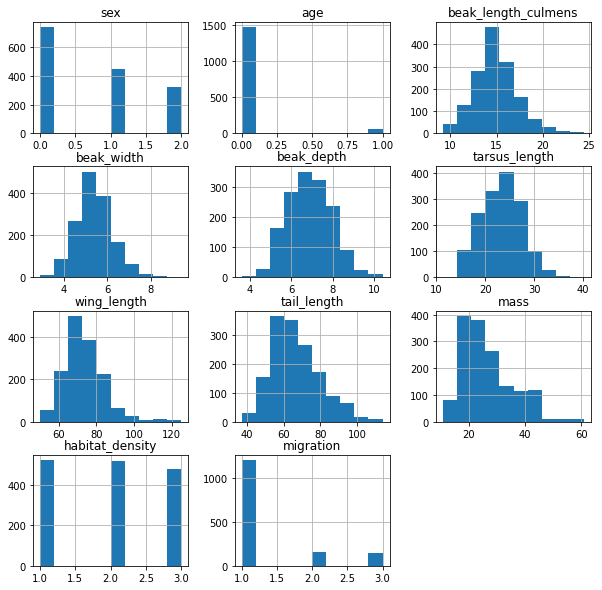

In [31]:
# View histograms of all numeric features
sparrows.hist(figsize = (10, 10))
plt.show()

All continuous variables are roughly normally distributed. Habitat_density is uniformly distributed between the three discrete categories. Sex, age, and migration are all right-skewed, indicating that there are more males than females or unknown specimens, most of the specimens were juveniles, and the majority of specimens do not migrate.

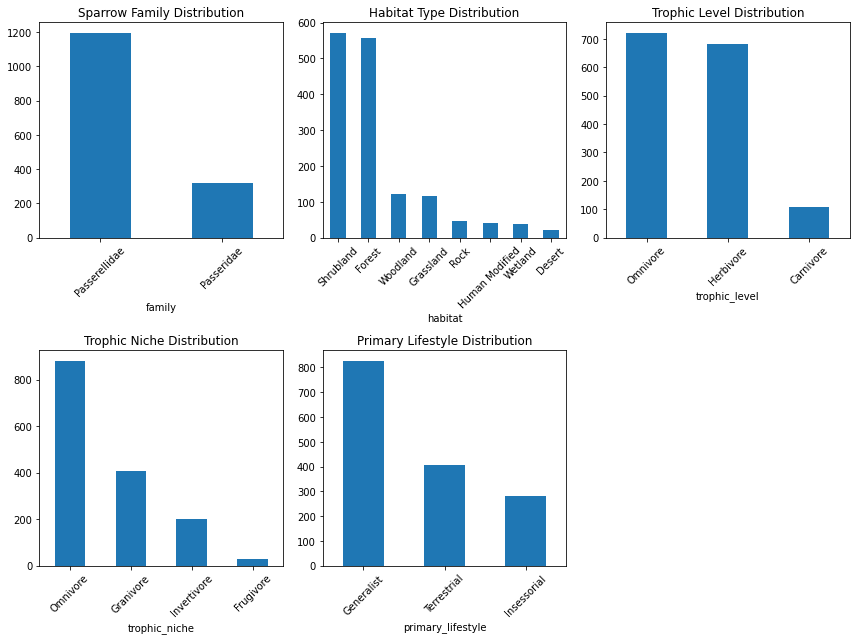

In [50]:
# View distributions of categorical features
fig = plt.figure(figsize=(12, 9))

plt.subplot(231)
sparrows.family.value_counts().plot(kind = 'bar', title = 'Sparrow Family Distribution')
plt.xticks(rotation = 45)

plt.subplot(232)
sparrows.habitat.value_counts().plot(kind = 'bar', title = 'Habitat Type Distribution')
plt.xticks(rotation = 45)

plt.subplot(233)
sparrows.trophic_level.value_counts().plot(kind = 'bar', title = 'Trophic Level Distribution')
plt.xticks(rotation = 45)

plt.subplot(234)
sparrows.trophic_niche.value_counts().plot(kind = 'bar', title = 'Trophic Niche Distribution')
plt.xticks(rotation = 45)

plt.subplot(235)
sparrows.primary_lifestyle.value_counts().plot(kind = 'bar', title = 'Primary Lifestyle Distribution')
plt.xticks(rotation = 45)

fig.tight_layout()
plt.show()

The family variable is heavily skewed towards Passerellidae, which will need to be accounted for when splitting into train and test sets. The majority of species included in this dataset live in primarily shrubland or forest habitats. The vast majority of specimens are primarily omnivores or herbivores, while a few are carnivores. Additionally, most of them also get the majority of their food resources from varied sources. Finally, most of the sparrows live a generalist lifestyle, spending their time in a wide variety of settings rather than any one specific one.

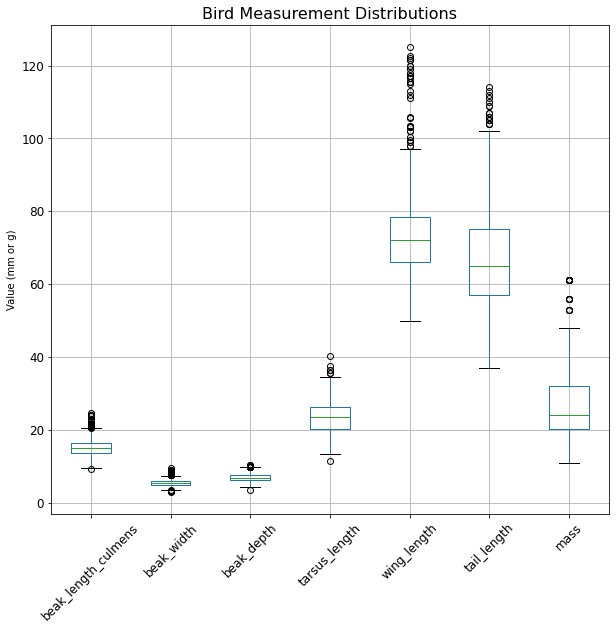

In [55]:
# View boxplots of continuous numeric variables
sparrows.boxplot(column = ['beak_length_culmens', 'beak_width', 'beak_depth', 'tarsus_length', 'wing_length',
                          'tail_length', 'mass'], fontsize = 12, rot = 45, figsize = (10, 9))
plt.title('Bird Measurement Distributions', fontsize = 16)
plt.ylabel('Value (mm or g)')
plt.show()

Wing length, tarsus length, and mass have the widest ranges. This makes sense because the beak measurements are much smaller values, so they have a smaller range of values. The wings and tail tend to be the longest measurements of a bird.

### Multivariate Analysis

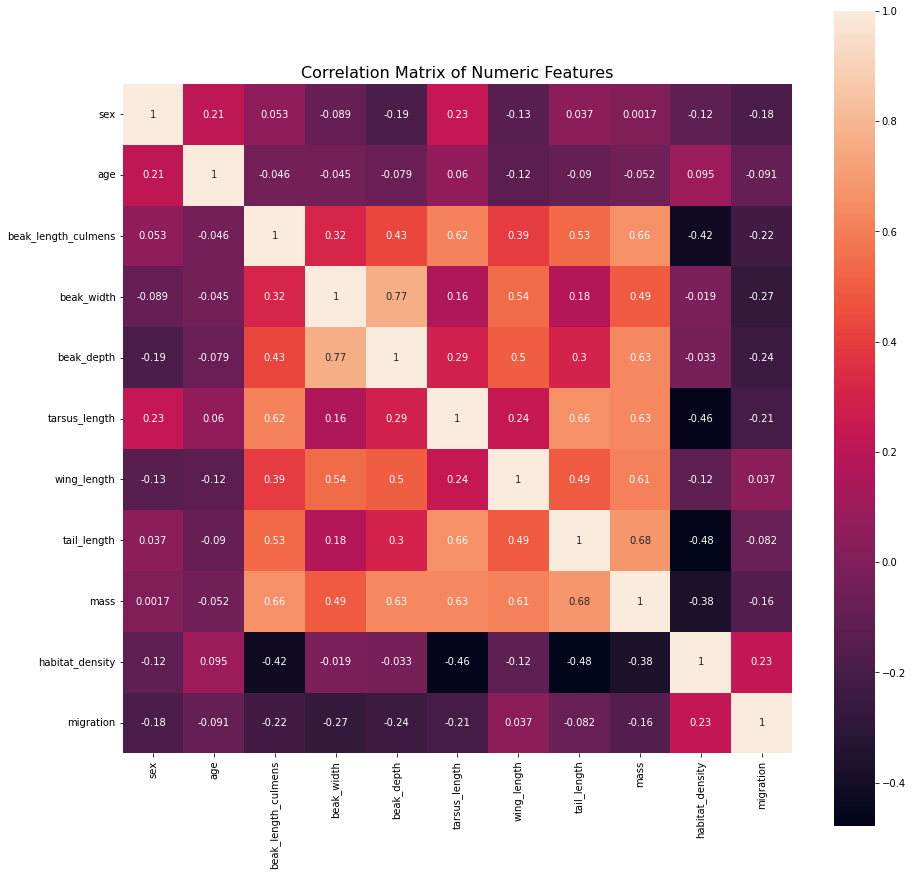

In [34]:
# Use a heatmap to check for multicollinearity of numeric values
plt.figure(figsize = (15, 15))
corr = sparrows.corr(numeric_only = True)
sns.heatmap(corr, annot=True, square=True)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of Numeric Features', fontsize = 16)
plt.show()

The pairs with the highest correlation are beak width/beak depth, tail length/mass, and beak length culmens/mass. However, none of the correlations are above 0.8, so the variables may still be usable together.

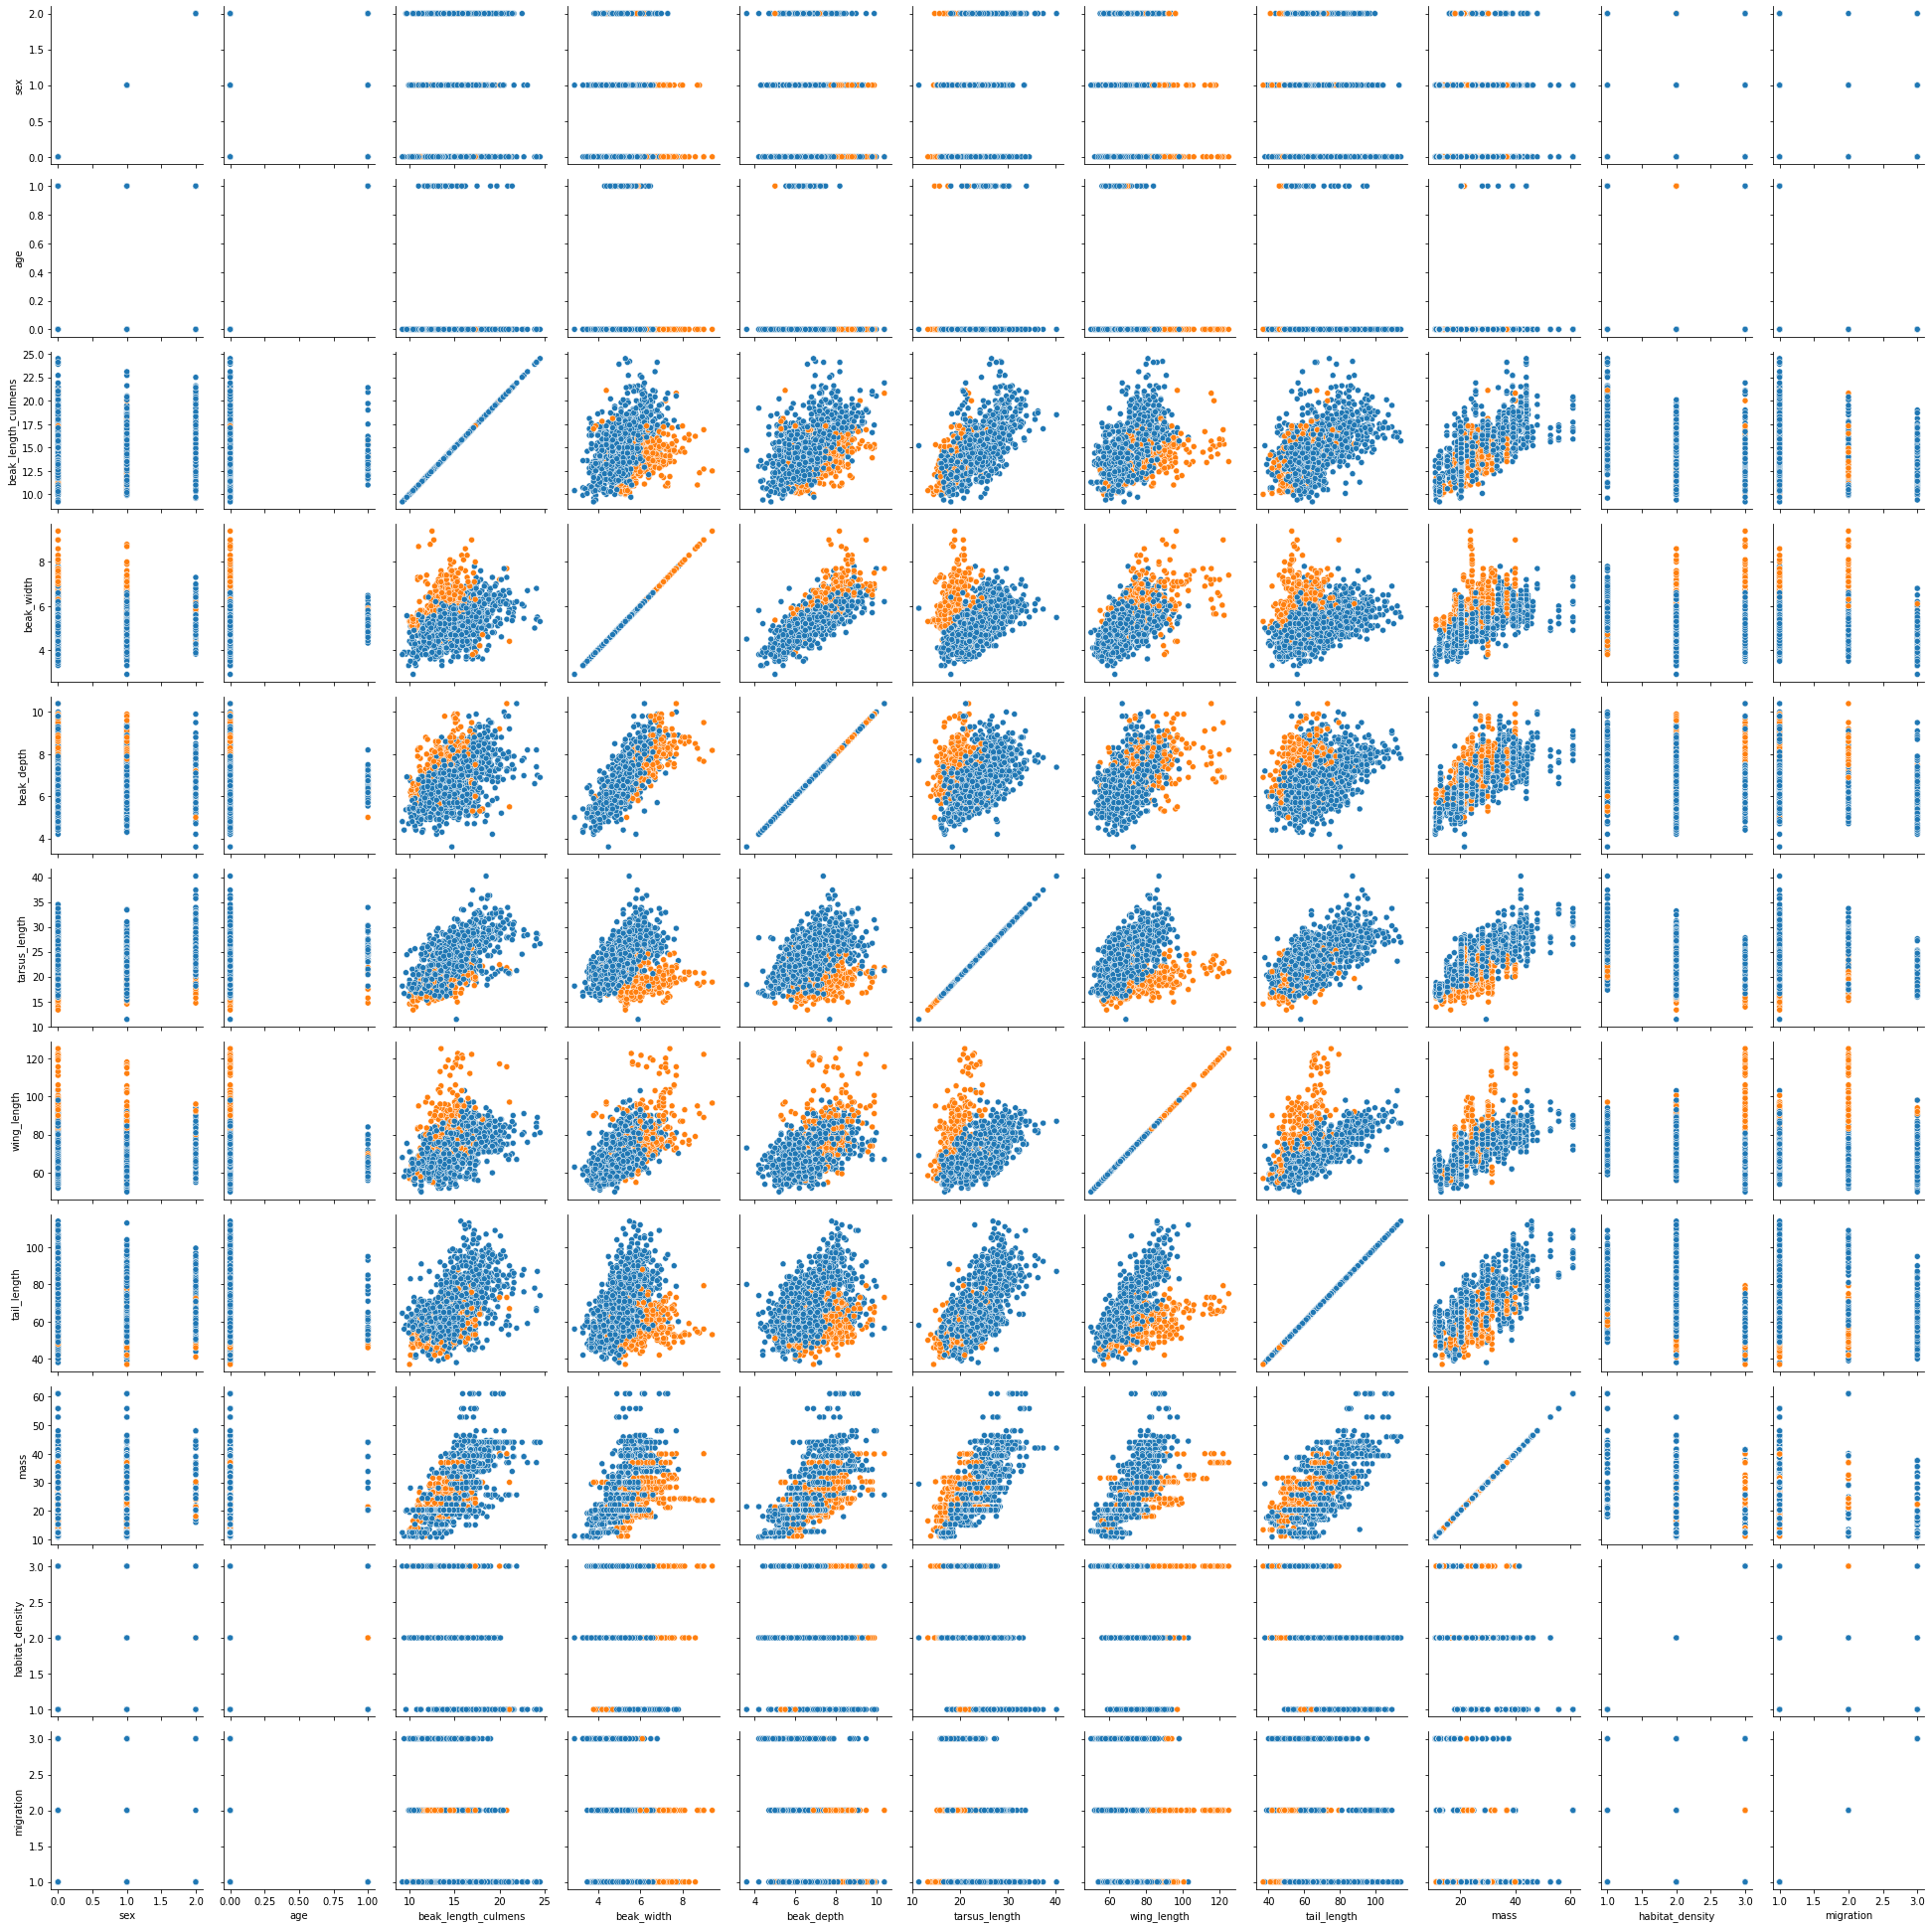

In [35]:
# View pairplots for all numeric columns
p = sns.PairGrid(sparrows, hue = 'family')
p.map(sns.scatterplot)
plt.show()

There are too many plots to see much detail, but this gives a good idea of which pairs might be linearly separable for closer inspection. None of the discrete numeric features look particularly promising.

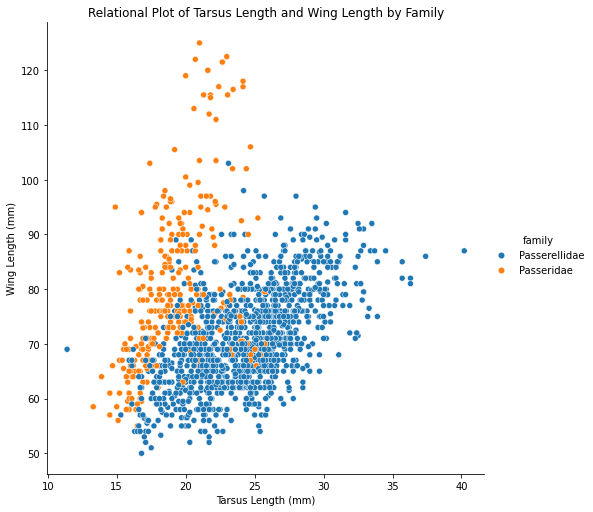

In [59]:
# View relational plot for promising variable combinations

sns.relplot(x = 'tarsus_length', y = 'wing_length', hue = 'family', data = sparrows, height = 7)
plt.title('Relational Plot of Tarsus Length and Wing Length by Family')
plt.xlabel('Tarsus Length (mm)')
plt.ylabel('Wing Length (mm)')
plt.show()

There is an area of overlap, but the families are somewhat linearly separable by wing length and tarsus length. Birds in the Passerellidae family tend to have longer legs for the same wing length compared to birds in the Passeridae family.

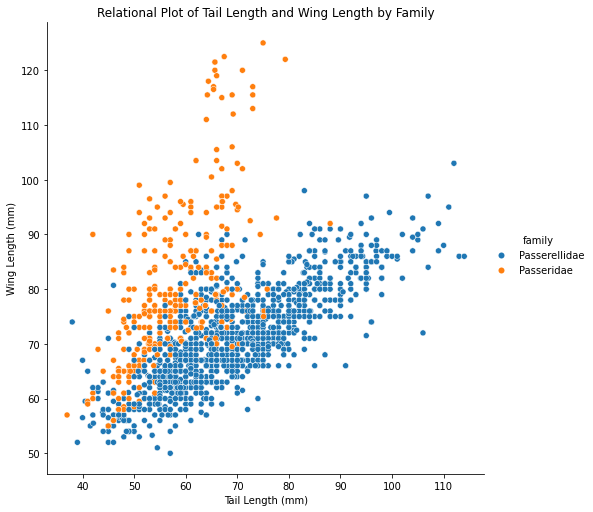

In [58]:
# Relational plot with tail length and wing length
sns.relplot(x = 'tail_length', y = 'wing_length', hue = 'family', data = sparrows, height = 7)
plt.title('Relational Plot of Tail Length and Wing Length by Family')
plt.xlabel('Tail Length (mm)')
plt.ylabel('Wing Length (mm)')
plt.show()

There is a decent linear separation between families with this combination. Members of the Passeridae family tend to have shorter tails for the same wing length as a member of the Passerellidae family.

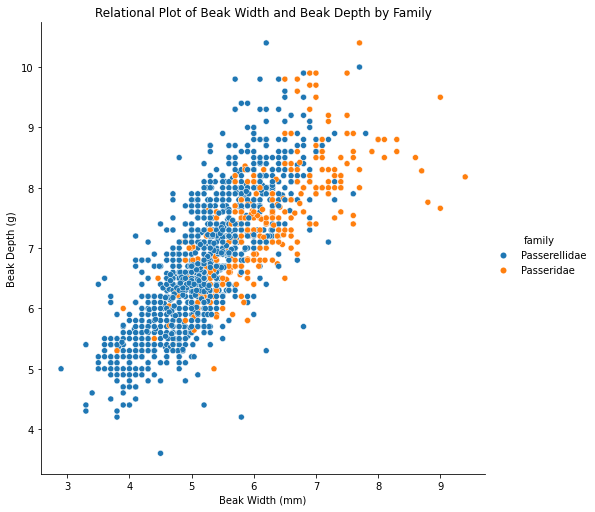

In [57]:
# Relational plot with beak width and beak depth
sns.relplot(x = 'beak_width', y = 'beak_depth', hue = 'family', data = sparrows, height = 7)
plt.title('Relational Plot of Beak Width and Beak Depth by Family')
plt.xlabel('Beak Width (mm)')
plt.ylabel('Beak Depth (g)')
plt.show()

There is not a very good linear separation between sparrow families by beak width and beak depth. However, old-world sparrows tend to have wider beaks for the same beak depth compared to new-world sparrows.

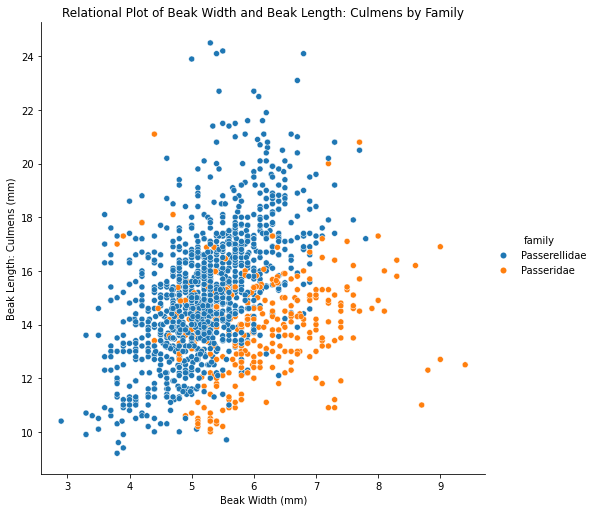

In [56]:
# Relational plot with beak width and beak depth
sns.relplot(x = 'beak_width', y = 'beak_length_culmens', hue = 'family', data = sparrows, height = 7)
plt.title('Relational Plot of Beak Width and Beak Length: Culmens by Family')
plt.xlabel('Beak Width (mm)')
plt.ylabel('Beak Length: Culmens (mm)')
plt.show()

The sparrow families are fairly linearly separable by beak length and beak width: culmens. Old-world sparrows tend to have wider beaks for the same total beak length as new-world sparrows.

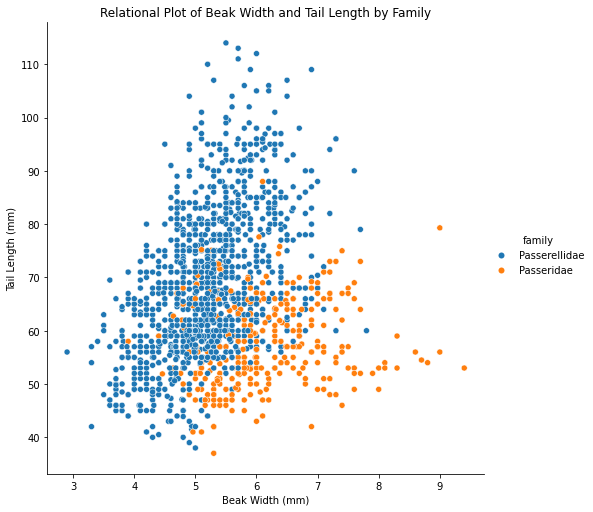

In [60]:
# Relational plot with beak width and tail length
sns.relplot(x = 'beak_width', y = 'tail_length', hue = 'family', data = sparrows, height = 7)
plt.title('Relational Plot of Beak Width and Tail Length by Family')
plt.xlabel('Beak Width (mm)')
plt.ylabel('Tail Length (mm)')
plt.show()

There is a decent linear separation between sparrow families by tail length and beak width. Birds in the Passeridae family tend to have wider beaks than those in the Passerellidae family for the same tail length.

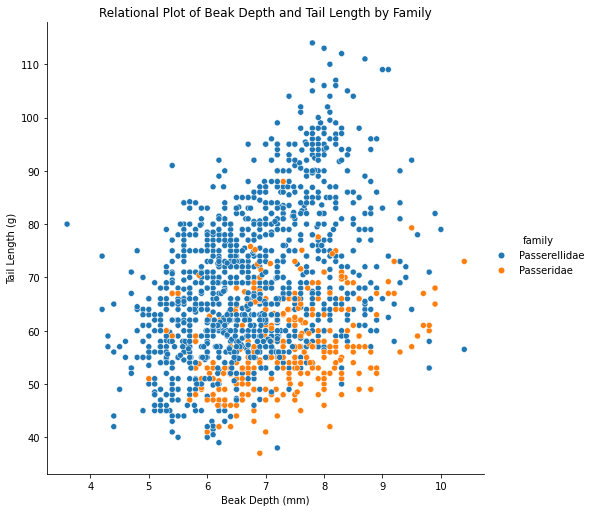

In [61]:
# Relational plot with beak depth and tail length
sns.relplot(x = 'beak_depth', y = 'tail_length', hue = 'family', data = sparrows, height = 7)
plt.title('Relational Plot of Beak Depth and Tail Length by Family')
plt.xlabel('Beak Depth (mm)')
plt.ylabel('Tail Length (g)')
plt.show()

There is not a very good separation between the sparrow families by tail length and beak depth. However, old-world sparrows tend to have deeper beaks for the same tail length than new-world sparrows overall.

# Predictive Models

## Preprocessing

In [62]:
# Choose relevant columns
sparrows.columns

Index(['sex', 'age', 'beak_length_culmens', 'beak_width', 'beak_depth',
       'tarsus_length', 'wing_length', 'tail_length', 'family', 'mass',
       'habitat', 'habitat_density', 'migration', 'trophic_level',
       'trophic_niche', 'primary_lifestyle'],
      dtype='object')

In [65]:
# Assign independent variables as X
X = sparrows[['sex', 'age', 'beak_length_culmens', 'beak_width', 'beak_depth', 'tarsus_length', 'wing_length',
              'tail_length']]

The continuous numeric features were the only ones that showed a consistent difference between the two family classes.

In [69]:
# Encode dependent variable as binary values
fam_dict = {'Passerellidae': 0, 'Passeridae': 1}
sparrows.replace({'family': fam_dict}, inplace = True)

In [75]:
# Assign dependent variable as y
y = sparrows.family

In [76]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [79]:
# Check that the stratified split has preserved the dependent class proportions
# split set
y_test.value_counts()/len(y_test)

family
0   0.789
1   0.211
Name: count, dtype: float64

In [80]:
# Original set
sparrows['family'].value_counts()/len(sparrows)

family
0   0.790
1   0.210
Name: count, dtype: float64

The proportions of Passerelidae to Passeridae is the same between the original and split datasets

In [81]:
# Train a StandardScaler instance using the training data
std_scaler = StandardScaler()
X_train_scale = std_scaler.fit_transform(X_train)

## Models

### Logistic Regression

In [105]:
# Create and fit logistic regression model
lr = LogisticRegression(C = 1.0, random_state = 42).fit(X_train_scale, y_train)

In [86]:
# Evaluate on training set using k-fold cross validation
lr_scores = -cross_val_score(lr, X_train_scale, y_train, scoring = 'neg_root_mean_squared_error', cv = 10)
pd.Series(lr_scores).describe()

count   10.000
mean     0.226
std      0.047
min      0.182
25%      0.203
50%      0.213
75%      0.223
max      0.328
dtype: float64

Mean and median are similar, and the standard deviation is around 20-25%.

In [87]:
# Predict y_train values
y_pred_lr = lr.predict(X_train_scale)

In [95]:
# Evaluate model performance on training data
print('Logistic Regression Model Training Performance')
print('Bias:', lr.intercept_)
print('Coefficients:', lr.coef_)
print('Score:', lr.score(X_train_scale, y_train))
print('MAE:', mean_absolute_error(y_train, y_pred_lr))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_lr)))
print('MSE:', mean_squared_error(y_train, y_pred_lr))
print('R^2:', r2_score(y_train, y_pred_lr))
print()

# Evaluate model performance on test data
X_test_scale = std_scaler.transform(X_test)
y_test_pred_lr = lr.predict(X_test_scale)

print('Logistic Regression Model Test Performance')
print('MAE:', mean_absolute_error(y_test, y_test_pred_lr))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))
print('MSE:', mean_squared_error(y_test, y_test_pred_lr))
print('R^2:', r2_score(y_test, y_test_pred_lr))

Logistic Regression Model Training Performance
Bias: [-2.74744883]
Coefficients: [[ 0.19092407  0.26195884 -0.52390011  1.23551869  0.13803103 -1.9454379
   2.09438733 -1.52114423]]
Score: 0.9496284062758051
MAE: 0.05037159372419488
RMSE: 0.22443616848492776
MSE: 0.05037159372419488
R^2: 0.6961016628407344

Logistic Regression Model Test Performance
MAE: 0.04950495049504951
RMSE: 0.2224970797449924
MSE: 0.04950495049504951
R^2: 0.7028634937238494


Performance is very similar for train and test sets.

In [162]:
# Tune hyperparameters using GridSearchCV
C_vals = [i for i in np.arange(0.5, 5.0, 0.5)]
lr_params = [
    {'penalty': ['l2'],
    'C': C_vals,
     'solver': ['lbfgs'],
    'random_state': [42]},
    {'penalty': ['l1', 'l2'],
    'C': [0.5, 5.0, 0.5],
     'solver': ['liblinear'],
    'random_state': [42]}
]
gs_lr = GridSearchCV(lr, lr_params, cv = 5)
gs_lr.fit(X_train_scale, y_train)

# View best parameters
gs_lr.best_params_

{'C': 0.5, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}

In [148]:
# Fit LR model with best parameters
lr_tuned = LogisticRegression(C = 0.5, penalty = 'l1', solver = 'liblinear', random_state = 42).fit(X_train_scale, y_train)

# Evaluate on training set using k-fold cross validation
lr_tune_scores = -cross_val_score(lr_tuned, X_train_scale, y_train, scoring = 'neg_root_mean_squared_error', cv = 10)
pd.Series(lr_tune_scores).describe()

count   10.000
mean     0.224
std      0.047
min      0.182
25%      0.203
50%      0.203
75%      0.223
max      0.328
dtype: float64

In [136]:
# Predict y_train values
y_pred_lr_tune = lr_tuned.predict(X_train_scale)

In [137]:
# Evaluate tuned model performance on training data
print('Tuned Logistic Regression Model Training Performance')
print('Bias:', lr_tuned.intercept_)
print('Coefficients:', lr_tuned.coef_)
print('Score:', lr_tuned.score(X_train_scale, y_train))
print('MAE:', mean_absolute_error(y_train, y_pred_lr_tune))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_lr_tune)))
print('MSE:', mean_squared_error(y_train, y_pred_lr_tune))
print('R^2:', r2_score(y_train, y_pred_lr_tune))
print()

# Evaluate model performance on test data
y_test_pred_lr_tune = lr_tuned.predict(X_test_scale)

print('Tuned Logistic Regression Model Test Performance')
print('MAE:', mean_absolute_error(y_test, y_test_pred_lr_tune))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred_lr_tune)))
print('MSE:', mean_squared_error(y_test, y_test_pred_lr_tune))
print('R^2:', r2_score(y_test, y_test_pred_lr_tune))

Tuned Logistic Regression Model Training Performance
Bias: [-2.65484734]
Coefficients: [[ 0.15000249  0.24310512 -0.45712244  1.26548565  0.05092995 -1.91484598
   2.02410377 -1.45384203]]
Score: 0.9504541701073493
MAE: 0.0495458298926507
RMSE: 0.22258892580865453
MSE: 0.0495458298926507
R^2: 0.7010836027941649

Tuned Logistic Regression Model Test Performance
MAE: 0.052805280528052806
RMSE: 0.22979399584857044
MSE: 0.052805280528052806
R^2: 0.6830543933054394


Almost identical to original model performance

### Random Forest

In [97]:
# Create and train a random forest model
rf = RandomForestClassifier(random_state = 42).fit(X_train_scale, y_train)

In [99]:
# Evaluate on training set using k-fold cross validation
rf_scores = -cross_val_score(rf, X_train_scale, y_train, scoring = 'neg_root_mean_squared_error', cv = 10)
pd.Series(rf_scores).describe()

count   10.000
mean     0.193
std      0.040
min      0.157
25%      0.157
50%      0.192
75%      0.203
max      0.273
dtype: float64

Mean and median are essentially the same, and min and 1st quartile are the same.

In [100]:
# Predict y_train values
y_pred_rf = rf.predict(X_train_scale)

In [103]:
# Evaluate model performance on training data
print('Random Forest Model Training Performance')
print('Score:', rf.score(X_train_scale, y_train))
print('MAE:', mean_absolute_error(y_train, y_pred_rf))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_rf)))
print('MSE:', mean_squared_error(y_train, y_pred_rf))
print('R^2:', r2_score(y_train, y_pred_rf))
print()

# Evaluate model performance on test data
y_test_pred_rf = rf.predict(X_test_scale)

print('Random Forest Model Test Performance')
print('MAE:', mean_absolute_error(y_test, y_test_pred_rf))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred_rf)))
print('MSE:', mean_squared_error(y_test, y_test_pred_rf))
print('R^2:', r2_score(y_test, y_test_pred_rf))

Random Forest Model Training Performance
Score: 1.0
MAE: 0.0
RMSE: 0.0
MSE: 0.0
R^2: 1.0

Random Forest Model Test Performance
MAE: 0.036303630363036306
RMSE: 0.19053511582654864
MSE: 0.036303630363036306
R^2: 0.7820998953974896


Very overfit

In [147]:
# Tune hyperparameters using GridSearchCV
estimators = [i for i in range(100, 1000, 100)]
rf_params = [
    {'n_estimators': estimators,
     'max_depth': [2, 3]}
]

gs_rf = GridSearchCV(rf, rf_params, cv = 5)
gs_rf.fit(X_train_scale, y_train)

# View best parameters
gs_rf.best_params_

{'max_depth': 3, 'n_estimators': 500}

In [149]:
# Fit RF model with best parameters
rf_tuned = RandomForestClassifier(max_depth = 3, n_estimators = 500, random_state = 42).fit(X_train_scale, y_train)

# Evaluate on training set using k-fold cross validation
rf_tune_scores = -cross_val_score(rf_tuned, X_train_scale, y_train, scoring = 'neg_root_mean_squared_error', cv = 10)
pd.Series(rf_tune_scores).describe()

count   10.000
mean     0.265
std      0.033
min      0.223
25%      0.244
50%      0.257
75%      0.294
max      0.315
dtype: float64

Improvement over original

In [150]:
# Predict y_train values
y_pred_rf_tune = rf_tuned.predict(X_train_scale)

In [151]:
# Evaluate tuned model performance on training data
print('Tuned Random Forest Classifier Model Training Performance')
print('Score:', rf_tuned.score(X_train_scale, y_train))
print('MAE:', mean_absolute_error(y_train, y_pred_rf_tune))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_rf_tune)))
print('MSE:', mean_squared_error(y_train, y_pred_rf_tune))
print('R^2:', r2_score(y_train, y_pred_rf_tune))
print()

# Evaluate model performance on test data
y_test_pred_rf_tune = rf_tuned.predict(X_test_scale)

print('Tuned Random Forest Model Test Performance')
print('MAE:', mean_absolute_error(y_test, y_test_pred_rf_tune))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred_rf_tune)))
print('MSE:', mean_squared_error(y_test, y_test_pred_rf_tune))
print('R^2:', r2_score(y_test, y_test_pred_rf_tune))

Tuned Random Forest Classifier Model Training Performance
Score: 0.9421965317919075
MAE: 0.057803468208092484
RMSE: 0.2404235184171725
MSE: 0.057803468208092484
R^2: 0.651264203259859

Tuned Random Forest Model Test Performance
MAE: 0.07590759075907591
RMSE: 0.2755133222896416
MSE: 0.07590759075907591
R^2: 0.544390690376569


Still overfit, and not as good as logistic regression model

### KNN Classification

In [155]:
# Create and fit a KNN classifier model
knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train_scale, y_train)

In [156]:
# Evaluate on training set using k-fold cross validation
knn_scores = -cross_val_score(knn, X_train_scale, y_train, scoring = 'neg_root_mean_squared_error', cv = 10)
pd.Series(knn_scores).describe()

count   10.000
mean     0.231
std      0.034
min      0.157
25%      0.222
50%      0.232
75%      0.257
max      0.273
dtype: float64

Mean and median are essentially the same, IQR smaller than for RF model.

In [108]:
# Predict y_train values
y_pred_knn = knn.predict(X_train_scale)

In [109]:
# Evaluate model performance on training data
print('KNN Classifier Model Training Performance')
print('Score:', knn.score(X_train_scale, y_train))
print('MAE:', mean_absolute_error(y_train, y_pred_knn))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_knn)))
print('MSE:', mean_squared_error(y_train, y_pred_knn))
print('R^2:', r2_score(y_train, y_pred_knn))
print()

# Evaluate model performance on test data
y_test_pred_knn = knn.predict(X_test_scale)

print('KNN Classifier Model Test Performance')
print('MAE:', mean_absolute_error(y_test, y_test_pred_knn))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred_knn)))
print('MSE:', mean_squared_error(y_test, y_test_pred_knn))
print('R^2:', r2_score(y_test, y_test_pred_knn))

KNN Classifier Model Training Performance
Score: 0.9661436829066887
MAE: 0.033856317093311314
RMSE: 0.18400086166458926
MSE: 0.033856317093311314
R^2: 0.795740461909346

KNN Classifier Model Test Performance
MAE: 0.039603960396039604
RMSE: 0.19900743804199783
MSE: 0.039603960396039604
R^2: 0.7622907949790795


Performance very similar on both models, and best R2 so far.

In [152]:
# Tune hyperparameters using GridSearchCV
knn_params = [
    {'n_neighbors': [3, 5, 7, 10],
     'weights': ['uniform', 'distance']}
]

gs_knn = GridSearchCV(knn, knn_params, cv = 5)
gs_knn.fit(X_train_scale, y_train)

# View best parameters
gs_knn.best_params_

{'n_neighbors': 10, 'weights': 'distance'}

In [153]:
# Fit KNN model with best parameters
knn_tuned = KNeighborsClassifier(n_neighbors = 10, weights = 'distance').fit(X_train_scale, y_train)

# Evaluate on training set using k-fold cross validation
knn_tune_scores = -cross_val_score(knn_tuned, X_train_scale, y_train, scoring = 'neg_root_mean_squared_error', cv = 10)
pd.Series(knn_tune_scores).describe()

count   10.000
mean     0.213
std      0.042
min      0.157
25%      0.182
50%      0.203
75%      0.236
max      0.287
dtype: float64

In [158]:
# Predict y_train values
y_pred_knn_tune = knn_tuned.predict(X_train_scale)

In [160]:
# Evaluate model performance on training data
print('Tuned KNN Classifier Model Training Performance')
print('Score:', knn_tuned.score(X_train_scale, y_train))
print('MAE:', mean_absolute_error(y_train, y_pred_knn_tune))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_knn_tune)))
print('MSE:', mean_squared_error(y_train, y_pred_knn_tune))
print('R^2:', r2_score(y_train, y_pred_knn_tune))
print()

# Evaluate model performance on test data
y_test_pred_knn_tune = knn_tuned.predict(X_test_scale)

print('Tuned KNN Classifier Model Test Performance')
print('MAE:', mean_absolute_error(y_test, y_test_pred_knn_tune))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred_knn_tune)))
print('MSE:', mean_squared_error(y_test, y_test_pred_knn_tune))
print('R^2:', r2_score(y_test, y_test_pred_knn_tune))

Tuned KNN Classifier Model Training Performance
Score: 1.0
MAE: 0.0
RMSE: 0.0
MSE: 0.0
R^2: 1.0

Tuned KNN Classifier Model Test Performance
MAE: 0.0462046204620462
RMSE: 0.214952600500776
MSE: 0.0462046204620462
R^2: 0.7226725941422594


This model is very overfit.

### Support Vector Classifier

In [111]:
# Create and fit an SVC model
sv = SVC(C = 1.0, kernel = 'rbf', random_state = 42).fit(X_train_scale, y_train)

In [113]:
# Evaluate on training set using k-fold cross validation
svc_scores = -cross_val_score(sv, X_train_scale, y_train, scoring = 'neg_root_mean_squared_error', cv = 10)
pd.Series(svc_scores).describe()

count   10.000
mean     0.225
std      0.048
min      0.181
25%      0.187
50%      0.213
75%      0.236
max      0.315
dtype: float64

Largest IQR so far

In [114]:
# Predict y_train values
y_pred_svc = sv.predict(X_train_scale)

In [115]:
# Evaluate model performance on training data
print('Support Vector Classifier Model Training Performance')
print('Score:', sv.score(X_train_scale, y_train))
print('MAE:', mean_absolute_error(y_train, y_pred_svc))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_svc)))
print('MSE:', mean_squared_error(y_train, y_pred_svc))
print('R^2:', r2_score(y_train, y_pred_svc))
print()

# Evaluate model performance on test data
y_test_pred_svc = sv.predict(X_test_scale)

print('Support Vecor Classifier Model Test Performance')
print('MAE:', mean_absolute_error(y_test, y_test_pred_svc))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred_svc)))
print('MSE:', mean_squared_error(y_test, y_test_pred_svc))
print('R^2:', r2_score(y_test, y_test_pred_svc))

Support Vector Classifier Model Training Performance
Score: 0.9570602807597027
MAE: 0.042939719240297276
RMSE: 0.20721901273844848
MSE: 0.042939719240297276
R^2: 0.7409391224216095

Support Vecor Classifier Model Test Performance
MAE: 0.0462046204620462
RMSE: 0.214952600500776
MSE: 0.0462046204620462
R^2: 0.7226725941422594


Ok performance, not much overfitting.

In [164]:
# Tune hyperparameters using GridSearchCV
svc_params = [
    {'C': C_vals,
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4],
    'random_state': [42]}
]

gs_svc = GridSearchCV(sv, svc_params, cv = 5)
gs_svc.fit(X_train_scale, y_train)

# View best parameters
gs_svc.best_params_

{'C': 0.5, 'degree': 2, 'kernel': 'linear', 'random_state': 42}

In [173]:
# Fit SVC model with best parameters
svc_tuned = SVC(C = 0.5, kernel = 'linear', random_state = 42).fit(X_train_scale, y_train)

# Evaluate on training set using k-fold cross validation
svc_tune_scores = -cross_val_score(svc_tuned, X_train_scale, y_train, scoring = 'neg_mean_squared_error', cv = 10)
pd.Series(svc_tune_scores).describe()

count   10.000
mean     0.050
std      0.021
min      0.033
25%      0.041
50%      0.041
75%      0.050
max      0.099
dtype: float64

Slightly better than original model

In [166]:
# Predict y_train values
y_pred_svc_tune = svc_tuned.predict(X_train_scale)

In [167]:
# Evaluate model performance on training data
print('Tuned Support Vector Classifier Model Training Performance')
print('Score:', svc_tuned.score(X_train_scale, y_train))
print('MAE:', mean_absolute_error(y_train, y_pred_svc_tune))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_svc_tune)))
print('MSE:', mean_squared_error(y_train, y_pred_svc_tune))
print('R^2:', r2_score(y_train, y_pred_svc_tune))
print()

# Evaluate model performance on test data
y_test_pred_svc_tune = svc_tuned.predict(X_test_scale)

print('Tuned Support Vecor Classifier Model Test Performance')
print('MAE:', mean_absolute_error(y_test, y_test_pred_svc_tune))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred_svc_tune)))
print('MSE:', mean_squared_error(y_test, y_test_pred_svc_tune))
print('R^2:', r2_score(y_test, y_test_pred_svc_tune))

Tuned Support Vector Classifier Model Training Performance
Score: 0.9479768786127167
MAE: 0.05202312138728324
RMSE: 0.22808577638091165
MSE: 0.05202312138728324
R^2: 0.6861377829338731

Tuned Support Vecor Classifier Model Test Performance
MAE: 0.0462046204620462
RMSE: 0.214952600500776
MSE: 0.0462046204620462
R^2: 0.7226725941422594


Very similar performance to original

### Model Comparison

| Best Model | Set | RMSE | R2 |
|:---|:---|:---|:---|
|Logistic Regression|Training|0.22|70.10|
||Test|0.23|68.30|
|Random Forest Classifier|Training|0.24|65.12|
||Test|0.28|54.44|
|KNN Classifier|Training|0.18|79.57|
||Test|0.20|76.23|
|Support Vector Classifier|Training|0.21|74.09|
||Test|0.21|72.70|

The KNN classifier had the best performance and little overfitting.

### References

1. Bhattarai, A., T., F.: Knnimputer. https://github.com/scikit-learn/
scikit-learn/blob/093e0cf14/sklearn/impute/_knn.py#L20 (2014), accessed
on October 31, 2023
2. Camfield, A.: Emberizidae buntings, american sparrows, and relatives. https://
animaldiversity.org/accounts/Emberizidae/ (2004), accessed on November 6,
2023
3. Cornell: New world sparrows—passerellidae. https://www.allaboutbirds.org/
guide/browse/taxonomy/Passerellidae (2023), accessed on November 6, 2023
4. Cornell: Old world sparrows—passeridae. https://www.allaboutbirds.org/
guide/browse/taxonomy/Passeridae (2023), accessed on November 6, 2023
5. Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O.,
Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A.,
Cournapeau, D., Brucher, M., Perrot, M., Duchesnay, E.: Scikit-learn: Machine
learning in Python. Journal of Machine Learning Research 12, 2825–2830 (2011)
6. Schuldheisz, C.: Fish and wildlife service delists 21 species from the endangered
species act due to extinction. https://www.fws.gov/press-release/2023-10/
21-species-delisted-endangered-species-act-due-extinction (2023), ac-
cessed on October 18, 2023
7. Tobias: Avonet: morphological, ecological and geographical data for all birds. https:
//figshare.com/s/b990722d72a26b5bfead (2022), accessed on October 18, 2023
8. Tobias, J.A., Sheard, C., Pigot, A.L., Devenish, A.J.M., Yang, J., Sayol, F., Neate-
Clegg, M.H.C., Alioravainen, N., Weeks, T.L., Barber, R.A., Walkden, P.A., Mac-
Gregor, H.E.A., Jones, S.E.I., Vincent, C., Phillips, A.G., Marples, N.M., Monta ̃no-
Centellas, F.A., Leandro-Silva, V., Claramunt, S., Darski, B., Freeman, B.G., Breg-
man, T.P., Cooney, C.R., Hughes, E.C., Capp, E.J.R., Varley, Z.K., Friedman,
N.R., Korntheuer, H., Corrales-Vargas, A., Trisos, C.H., Weeks, B.C., Hanz, D.M.,
T ̈opfer, T., Bravo, G.A., Remeˇs, V., Nowak, L., Carneiro, L.S., Moncada R., A.J.,
Matysiokov ́a, B., Baldassarre, D.T., Mart ́ınez-Salinas, A., Wolfe, J.D., Chapman,
P.M., Daly, B.G., Sorensen, M.C., Neu, A., Ford, M.A., Mayhew, R.J., Fabio Sil-
veira, L., Kelly, D.J., Annorbah, N.N.D., Pollock, H.S., Grabowska-Zhang, A.M.,
McEntee, J.P., Carlos T. Gonzalez, J., Meneses, C.G., Mu ̃noz, M.C., Powell, L.L.,
Jamie, G.A., Matthews, T.J., Johnson, O., Brito, G.R.R., Zyskowski, K., Crates,
R., Harvey, M.G., Jurado Zevallos, M., Hosner, P.A., Bradfer-Lawrence, T., Maley,
J.M., Stiles, F.G., Lima, H.S., Provost, K.L., Chibesa, M., Mashao, M., Howard,
J.T., Mlamba, E., Chua, M.A.H., Li, B., G ́omez, M.I., Garc ́ıa, N.C., P ̈ackert,
M., Fuchs, J., Ali, J.R., Derryberry, E.P., Carlson, M.L., Urriza, R.C., Brzeski,
K.E., Prawiradilaga, D.M., Rayner, M.J., Miller, E.T., Bowie, R.C.K., Lafontaine,
R.M., Scofield, R.P., Lou, Y., Somarathna, L., Lepage, D., Illif, M., Neuschulz,
E.L., Templin, M., Dehling, D.M., Cooper, J.C., Pauwels, O.S.G., Analuddin, K.,
Fjelds ̊a, J., Seddon, N., Sweet, P.R., DeClerck, F.A.J., Naka, L.N., Brawn, J.D.,
Aleixo, A., B ̈ohning-Gaese, K., Rahbek, C., Fritz, S.A., Thomas, G.H., Schleuning,
M.: Avonet: morphological, ecological and geographical data for all birds. Ecology
Bird Identification Model 7
Letters 25(3), 581–597 (2022). https://doi.org/https://doi.org/10.1111/ele.13898,
https://onlinelibrary.wiley.com/doi/abs/10.1111/ele.13898


In [42]:
# Display system data
from watermark import watermark
print(watermark())

Last updated: 2023-11-07T21:05:17.566612-06:00

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

Compiler    : Clang 12.0.0 
OS          : Darwin
Release     : 23.0.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

